In [1]:
import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd

from src import *

# 1. Prepare

In [2]:
tickers = find_valid_universe()
print(f"Our universe contains {len(tickers)} tickers in total.")

Our universe contains 397 tickers in total.


In [3]:
ratio = calc_ratio(use_cache=True, use_data_cache=True, tickers=tickers
                   ).dropna(how="all", axis=1)
ratio_col = list(set(ratio_col).intersection(ratio.columns))
ratio.shape

(98574, 69)

In [4]:
print(f"Ratio list (n={len(ratio_col)}): {ratio_col}")

Ratio list (n=68): ['cmo', 'BR', 'skew', 'kurt_skew', 'oper_profit_margin', 'ret_asset', 'PVO', 'ret_0_1', 'fluc', 'p_volatility', 'ERBE', 'free_cash_flow', 'rev_growth', 'volume_shock', 'asset_growth', 'VEMA12', 'NPR', 'lterm_debt_cap', 'pretax_profit_margin', 'price_pos', 'oper_cash_flow_per_share', 'day_sale_rcv', 'ret_autocorr', 'ret_equity', 'quantile_95', 'pe', 'profit_margin', 'rs_volatility', 'excl_exp', 'alpha6', 'rcv_turn', 'BIASVOL', 'cash_profit', 'tot_debt_tot_equity', 'book_val_per_share', 'HMA', 'yz_volatility', 'invty_turn', 'illiquidity', 'K20', 'DC', 'TURN10', 'bias', 'gross_margin', 'rd_bias', 'win_pct', 'VSTD20', 'AD', 'FI', 'DPO', 'asset_turn', 'ret_6_12', 'free_cash_flow_per_share', 'Altman_Z_Score', 'z_score', 'AR', 'AU', 'curr_ratio', 'RPPS', 'ret_tang_equity', 'alpha12', 'ret_1_6', 'V20', 'ERBU', 'ebit_margin', 'ulcer', 'ret_invst', 'macd']


In [5]:
factor = calc_factor(use_cache=False, ratio=ratio)
factor.shape

(290, 68)

In [6]:
df_ff = get_ff_data()
df_ff.shape
price = pd.read_pickle("data/price.pkl")["adj_close"].unstack("ticker")

price = fill_price_dates(price, droplevel=False).ffill()
price.shape

(8822, 392)

In [7]:
from typing import Callable
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def get_least_corr(df: pd.DataFrame, n: int = 5) -> dict[datetime, list[str]]:
    # Compute the correlation matrix and take the absolute value
    corr_matrix = df.corr().abs()
    
    # Initialize the list of selected columns with the column having the lowest average correlation
    selected_columns = [corr_matrix.mean().idxmin()]
    remaining_columns = list(set(df.columns) - set(selected_columns))
    
    # Iteratively add columns with the lowest average correlation to the selected columns
    while len(selected_columns) < n:
        avg_corr = corr_matrix[selected_columns].mean(axis=1).drop(selected_columns)
        next_column = avg_corr.idxmin()
        if avg_corr.notnull().sum() == 0:
            break
        selected_columns.append(next_column)
        remaining_columns.remove(next_column)
    
    return selected_columns

def get_least_vif(df: pd.DataFrame, 
                  n: int = 5, 
                  vif_trh: int = 10) -> dict[datetime, list[str]]:
    
    def calculate_max_vif(col):
        nonlocal df
        df_with_const = add_constant(df[col].dropna(how="any"))
        if len(df_with_const) == 0:
            return np.inf
        vif = pd.Series(
            [variance_inflation_factor(df_with_const.values, i) 
             for i in range(df_with_const.shape[1])],
            index=df_with_const.columns
        )
        return vif.max()

    selected_columns = get_least_corr(df, n=1)
    remaining_columns = df.columns.tolist()
    
    while len(selected_columns) < n and len(remaining_columns) > 0:
        vif_values = {}
        for column in remaining_columns:
            test_columns = selected_columns + [column]
            max_vif = calculate_max_vif(test_columns)
            vif_values[column] = max_vif
        
        min_vif_column = min(vif_values, key=vif_values.get)
        if vif_values[min_vif_column] < vif_trh:  # Assuming a VIF threshold of 10
            selected_columns.append(min_vif_column)
            remaining_columns.remove(min_vif_column)
        else:
            break  # Stop if adding any of the remaining columns results in high VIF
    
    return selected_columns

def iter_dates(
        func: Callable, 
        df: pd.DataFrame, 
        min_period: int = 12,
        *args, **kwargs,
) -> dict[datetime, list[str]]:
    results = {}
    df = df.sort_index()
    
    for i in range(min_period, len(df)):
        # factor dataframe index was lagged by 1 period
        eval_date = df.index[i] + pd.offsets.MonthEnd(1)
        # print(eval_date)
        results[eval_date] = func(df.iloc[:i], *args, **kwargs,)
    return results

In [ ]:
# vif_factors = iter_dates(get_least_vif, factor)
# vif_factors

In [ ]:
# corr_factors = iter_dates(get_least_corr, factor)
# corr_factors

In [16]:
def backtest_pipe(
    name: str,
    factor_chosen: dict[datetime, list[str]],
    ratio: pd.DataFrame = ratio,
    pred_func: Callable = ols_2, 
    start_date: datetime = datetime(2007, 5, 31),
    return_return: bool = False,
) -> pd.Series:
    """
    Combine single stock prediction, backtest position calculation, and 
    backtest PnL tracking in the same function for easy use.
    
    Parameters
    ----------
    name: str
        Describe how factor are selected
    factor_chosen: dict[datetime, list[str]]
        a dictionary of factor selected
    ratio: pd.DataFrame
        Index: (date, ticker)
        column: ratios + forward return
    pred_func: Callable
        single stock prediction function, default = OLS.

    Returns
    -------
    pd.Series: 
        backtest cumulative return results evaluation, e.g. sharpe...
        
    This function also draw plot of cumulative with given name.
    """
    # Equity return prediction
    predicted_returns = pred_func(
        ratio=ratio, factor_chosen=factor_chosen, fillna=True)
    predicted_returns.to_pickle(f"data/pred_ret_{name}.pkl")
    
    # Trading backtest
    INIT_CAPITAL = 2e7
    position = portfolio_equal_weighted(
        df_price=price, 
        df_ratio=predicted_returns.loc[start_date:].unstack("ticker"),
        rank_formula="predicted_ret",
        lb=0,
        ub=0.1,
        interval=None,
        use_change=False,
        position_size=INIT_CAPITAL / 20
    )
    trade_cls = CalcTrade(
        df_price=price,
        init_cap=INIT_CAPITAL
    )
    summary_df = trade_cls.iter_dates(position=position)
    summary_df["total_ret"].rename(name).plot(figsize=(12,4), title="Entire Period Return")
    if return_return:
        return summary_df["total_ret"]
    else:
        return pd.Series({
            **eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12),
            **ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
        }, name=name) 

# 2. Lasso

In [9]:
from sklearn.linear_model import Lasso
from functools import partial

Not trained on 1999-12-31 00:00:00: No ratio data on train/test date


return           -0.052919
mean             -0.000080
std               0.005289
skew              0.798185
kurtosis          6.722640
sharpe           -0.275639
sharpe_mkt       -0.011630
sortino          -0.404563
var              -0.027654
cvar             -0.041808
max_drawdown     -0.049487
downside_beta    -0.032764
alpha            -0.429837
beta_Mkt-RF       0.123948
beta_SMB         -0.110290
beta_HML          1.042279
beta_RF          23.805052
Name: Lasso, dtype: float64

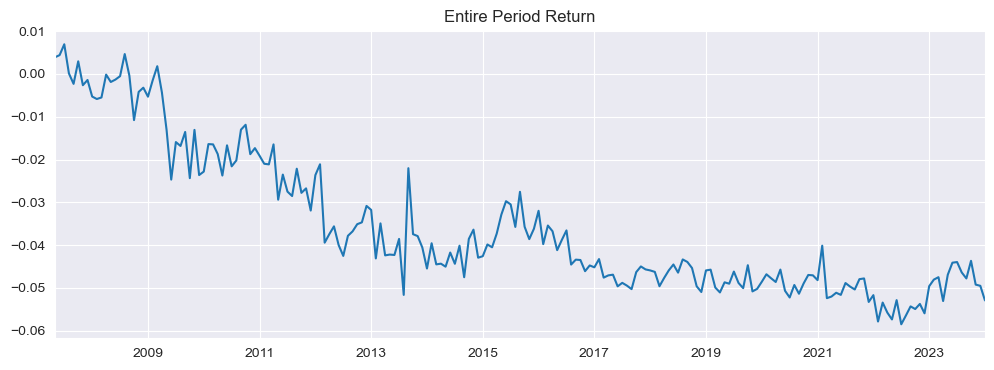

In [14]:
# select_ratio_col = [
#     "BR",
#     "AR",
#     "alpha12",
#     "ERBE",
#     "yz_volatility",
#     "rs_volatility",
#     "book_val_per_share",
#     "p_volatility",
#     "TURN10",
#     "z_score"
# ]
backtest_pipe(
    "Lasso", 
    {d: ratio_col for d in ratio.index.get_level_values("date")}, 
    pred_func=partial(ols_2, 
                      model_cls=partial(Lasso, alpha=0.001),
                      fillna=True)
)

# 3. Least correlated Factor
## 3.1. pred current vs pred future

In [ ]:
sample_factors = iter_dates(get_least_corr, factor, n=15)
backtest_pipe("pred_forward", sample_factors, pred_func=ols_2)
backtest_pipe("pred_current", sample_factors, pred_func=partial(ols_2, pred_col="ret_0_1"))
plt.legend()

## 3.2. pred method 1 vs 2

In [ ]:
backtest_pipe("OLS 1", sample_factors, pred_func=ols_1)
backtest_pipe("OLS 2", sample_factors, pred_func=ols_2)
plt.legend()

# 3.3. Least correlated (Diff number of factor)

Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date


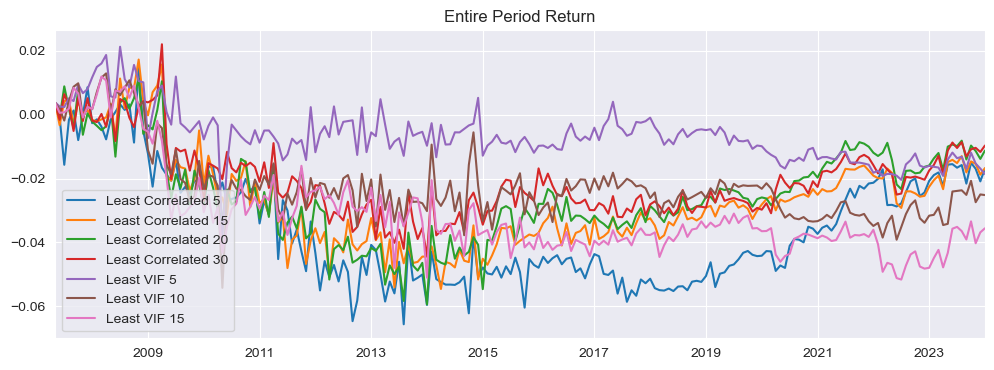

In [17]:
results = {}
for (name, factor_chosen) in [
    ("Least Correlated 5", iter_dates(get_least_corr, factor, n=5)),
    ("Least Correlated 15", iter_dates(get_least_corr, factor, n=15)),
    ("Least Correlated 20", iter_dates(get_least_corr, factor, n=20)),
    ("Least Correlated 30", iter_dates(get_least_corr, factor, n=30)),
    ("Least VIF 5", iter_dates(get_least_vif, factor, n=5)),
    ("Least VIF 10", iter_dates(get_least_vif, factor, n=10)),
    ("Least VIF 15", iter_dates(get_least_vif, factor, n=15)),
]:
    results[name] = backtest_pipe(name, factor_chosen, pred_func=ols_2)
    plt.legend()

In [18]:
pd.DataFrame(results).T.sort_values("sharpe", ascending=False)

,return,mean,std,skew,kurtosis,sharpe,sharpe_mkt,sortino,var,cvar,max_drawdown,downside_beta,alpha,beta_Mkt-RF,beta_SMB,beta_HML,beta_RF
Least VIF 5,-0.018594,0.000554,0.005040,0.537077,4.129563,0.146273,0.011755,0.221611,-0.026069,-0.039497,-0.028409,0.003469,-0.076989,0.007284,-0.032633,0.576612,16.937427
Least VIF 15,-0.035557,0.000484,0.006042,0.437483,4.585061,0.082372,0.009190,0.115612,-0.034695,-0.045555,-0.036452,-0.141501,-0.388338,0.137298,-0.019834,0.938176,72.284939
Least VIF 10,-0.025157,0.000434,0.006573,0.586757,3.525423,0.049077,0.007334,0.074638,-0.038307,-0.049766,-0.044732,-0.039948,-0.286754,0.074323,-0.034328,0.818479,80.115758
Least Correlated 30,-0.009650,0.000325,0.005525,0.336571,2.448946,-0.010308,0.003321,-0.015356,-0.030618,-0.041716,-0.035545,-0.005940,-0.286239,0.056001,-0.074804,0.301343,116.083782
Least Correlated 15,-0.016719,0.000139,0.005686,-0.306282,1.894201,-0.124510,-0.003525,-0.158573,-0.037225,-0.050431,-0.070222,-0.091634,-0.378498,0.066295,-0.068534,0.398772,169.018143
Least Correlated 20,-0.011224,0.000080,0.006696,-0.030264,2.503883,-0.135596,-0.005683,-0.180734,-0.036628,-0.056690,-0.056745,0.024234,-0.360208,0.059818,-0.053178,0.149238,180.570934
Least Correlated 5,-0.016843,-0.000188,0.006999,-0.229713,3.160714,-0.262871,-0.015506,-0.341333,-0.040576,-0.056076,-0.111739,0.089914,-0.486233,-0.008813,-0.013366,0.582742,192.045403


# Final Selection

In [ ]:
corr_15 = iter_dates(get_least_corr, factor, n=15)
vif_10 = iter_dates(get_least_vif, factor, n=10)

In [ ]:
vif_10

In [ ]:
corr_15

In [ ]:
pred_df, model_dict = ols_2(
    ratio,
    factor_chosen={d: ratio_col for d in ratio.index.get_level_values("date")},
    model_cls=partial(Lasso, alpha=0.001),
    fillna=True,
    return_model=True
)

In [ ]:
lasso_factor = {k: [i for i, coef in zip(ratio_col, v.coef_) if coef != 0] for k, v in model_dict.items()}
lasso_factor

In [ ]:
pd.DataFrame({
    "corr_15": corr_15,
    "vif_10": vif_10,
    "lasso": lasso_factor
}).to_pickle("data/factor_selection_lasso_least_corr.pkl")